In [1]:
import casadi as ca
import numpy as np

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.pyplot as plt

In [2]:
Nx = 2
N_iter = 8
x_lim = 10
y_lim = 10
delta = 1

x_init = ca.DM([2.5,2.5])

# diag_1 = 1
# diag_2 = 10
x_SX = ca.SX.sym('x',Nx)
# Hq = ca.diag([diag_1,diag_2])
# f = x_SX.T @ Hq @ x_SX
f = x_SX[0] ** 2 + ca.sin(x_SX[1]) 

f_func = ca.Function("f_func",[x_SX],[f])
H,g = ca.hessian(f,x_SX)

grad_func = ca.Function("grad_func", [x_SX],[g])
hessian_func = ca.Function("hessian_func", [x_SX],[H])

### Wolfe condition

1. Univariate function: $\phi(\alpha)=f\left(x_{k}+\alpha p_{k}\right), \quad \alpha>0$
2. conditions
    1. Sufficient decrease (or called Armijo condition): $f\left(x_{k}+\alpha p_{k}\right) \leq f\left(x_{k}\right)+c_{1} \alpha \nabla f_{k}^{T} p_{k}$ with $c_{1} \in(0,1)$
    2. curvature condition (to rule out unacceptably short steps): $\nabla f\left(x_{k}+\alpha_{k} p_{k}\right)^{T} p_{k} \geq c_{2} \nabla f_{k}^{T} p_{k}$ (Interpretation: $\phi^{\prime}\left(\alpha_{k}\right)$ $\ge$ $c_2 \phi^{\prime}(0)$) , for some constant $c_{2} \in\left(c_{1}, 1\right)$.
3. The strong Wolfe condition:
    2. $\| \nabla f\left(x_{k}+\alpha_{k} p_{k}\right)^{T} p_{k}\left|\leq c_{2}\right| \nabla f_{k}^{T} p_{k} \mid$

In [3]:
def plot_phi(f_func,xk,pk,alpha_sel):
    alpha = np.arange(0,1,0.01)
    N_alpha = np.shape(alpha)[0]

    phi_list = []

    for i in range(N_alpha):
        alpha_i = alpha[i]
        phi_list += [f_func(xk + alpha_i * pk).full().flatten().tolist()]
    
    fig, ax = plt.subplots()
    ax.plot(alpha,phi_list)
    ax.scatter(alpha_sel,f_func(xk + alpha_sel * pk).full().flatten().tolist(),s=50, color='r', zorder = 10, label='alpha =' + str(alpha_sel)) 
    ax.legend()

In [4]:
def Wolfe_condition(f_func, grad_func, c1, c2, xk, pk):
    alpha = 1
    while(True):
        if alpha <= 1e-9:
            return alpha
        cond_armijo = (f_func(xk + alpha * pk) <= f_func(xk) + c1 * alpha * grad_func(xk).T @ pk)
        cond_curvature = (grad_func(xk + alpha * pk).T @ pk >= c2 * grad_func(xk).T @ pk)
        if cond_armijo == True and cond_curvature == True:
            return alpha
        else: alpha = alpha * 0.9

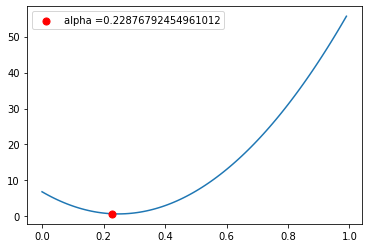

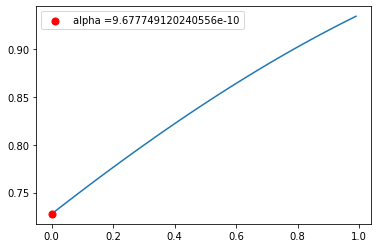

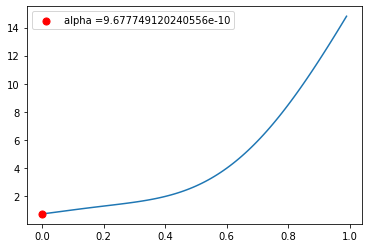

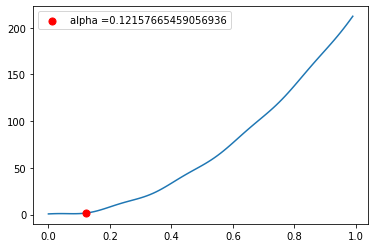

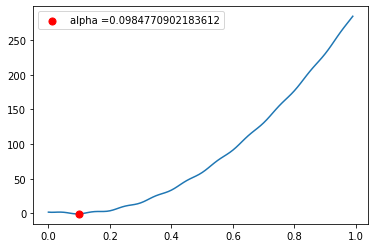

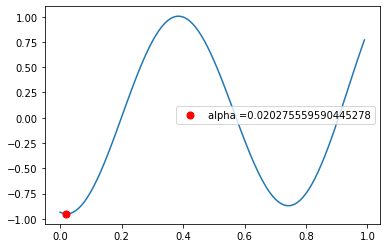

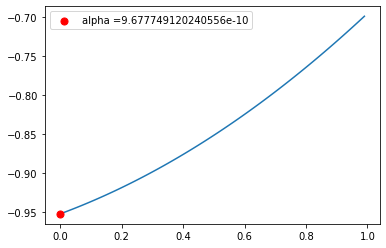

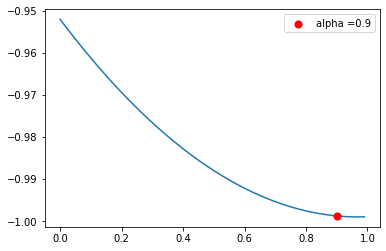

In [5]:
# H0 = ca.inv(Hq) / 2
H0 = hessian_func(x_init)
Hk = H0
xk = x_init
x_list = []

alpha = 1 # Should be computed from a line search.
I = ca.diag([1,1])

c1 = 0.5
c2 = 0.9    #  For a Newton or quasi-Newton method, choose c2 = 0.9

for i in range(N_iter):
    x_list += xk.full().flatten().tolist()
    grad_k = grad_func(xk)
#     print(grad_k)
    pk = - Hk @ grad_k
    # Step lenght

    alpha = Wolfe_condition(f_func, grad_func, c1, c2, xk, pk)
    plot_phi(f_func,xk,pk,alpha)
    x_plus = xk + pk * alpha
    grad_plus = grad_func(x_plus)
    
    sk = x_plus - xk
    yk = grad_plus - grad_k
    rho_k = 1 / (yk.T @ sk) 
    Hk = (I - rho_k * sk @ yk.T) @ Hk @ ( I - rho_k * sk @ yk.T) + rho_k @ sk @ sk.T
    xk = x_plus



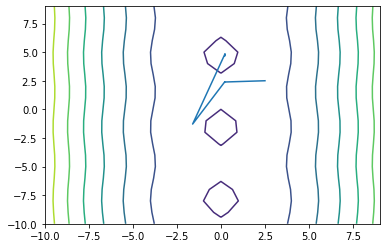

In [6]:
x = np.arange(-x_lim, x_lim, delta)
y = np.arange(-y_lim, y_lim, delta)
X, Y = np.meshgrid(x, y)
Z = X **2 + np.sin(Y) 
fig, ax = plt.subplots()
x1 = x_list[::2]
x2 = x_list[1::2]
ax.plot(x1,x2)
CS = ax.contour(X, Y, Z)